In [4]:
import torch

data = torch.arange(0, 1000, 1)
src = data[:-2]
print(src)  
src = data[1:-1]
print(src)  

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [5]:
%load_ext autoreload
%autoreload 2

import sys,os
import torch
import yaml
import logging
import pytorch_lightning as pl
from pydantic import ValidationError

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd()))))))
from datasets.weather_bench import WeatherDataset
from models.GPT.datasets.dataset import ValidationDataset
from models.GPT.training.configs import TrainingConfig
from models.GPT.training.configs import TrainingRunConfig

def get_normal_dataset(config: TrainingConfig):
    device = ("cuda" if torch.cuda.is_available() else "cpu" )
    device = torch.device(device)

    vars = config.air_variable + config.surface_variable + config.only_input_variable + config.constant_variable

    weather = WeatherDataset(config.train_start, config.train_end, device=device, download_variables=vars, download_levels=config.levels)
    # dataset.shape:  torch.Size([7309, 100, 1450])
    
    source, mean_std, var_vocab = weather.load_one(config.air_variable, config.surface_variable, config.only_input_variable, 
                                        config.constant_variable, level=config.levels)
    
    var_list = var_vocab.get_code(vars)
    dataset = ValidationDataset(source, config.time_len, 24 * 3)
    return dataset, mean_std, var_list

config_path = os.path.join(os.path.dirname(os.getcwd()), 'configs/train_config.yaml')

try:
    with open(config_path) as f:
        config_dict = yaml.safe_load(f)
    config: TrainingRunConfig = TrainingRunConfig.parse_obj(config_dict)
except FileNotFoundError:
    logging.error(f"Config file {config_path} does not exist. Exiting.")
except yaml.YAMLError:
    logging.error(f"Config file {config_path} is not valid YAML. Exiting.")
except ValidationError as e:
    logging.error(f"Config file {config_path} is not valid. Exiting.\n{e}")
else:
    pl.seed_everything(config.seed)


dataset, mean_std, var_list = get_normal_dataset(config.training)

Seed set to 123


데이터셋 불러오는 중...
2013-01-01T00:00:00.000000000
2022-01-01T00:00:00.000000000
==== LOAD DATASET ====
 <xarray.Dataset>
Dimensions:                  (time: 78889, latitude: 36, longitude: 36, level: 8)
Coordinates:
  * latitude                 (latitude) float64 20.04 20.74 ... 43.95 44.65
  * level                    (level) int64 50 100 250 500 600 700 850 925
  * longitude                (longitude) float64 115.3 116.0 ... 139.2 139.9
  * time                     (time) datetime64[ns] 2013-01-01 ... 2022-01-01
Data variables:
    10m_u_component_of_wind  (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    10m_v_component_of_wind  (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    2m_temperature           (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    geopotential             (time, level, latitude, longitude) float32 dask.array<chunksize=(256, 8, 36, 36), meta

100%|██████████| 12/12 [00:31<00:00,  2.59s/it]


36.38862 sec


In [6]:
%load_ext autoreload
%autoreload 2

from models.GPT.training.lightning import TrainModule

model = TrainModule.load_from_checkpoint('/workspace/Haea_dev/models/GPT/tb_logs/lightning_logs/3v07yowd/checkpoints/epoch=4-step=45080.ckpt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/workspace/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [7]:
from torch.utils.data import DataLoader, Dataset
import tqdm

test_ds, _ = torch.utils.data.random_split(
            dataset,
            [0.05, 0.95],
        )

data_loader = DataLoader(test_ds, batch_size=16, shuffle=True, num_workers=4)
results = []
epoch = 1
model.setting()

for i, batch in enumerate(tqdm.tqdm(data_loader)):
        result = model(batch, 24 * 3)
        results.append(result)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:03<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [4]:
results = torch.cat(results, dim=0)

In [5]:
print(results.shape)

torch.Size([165, 72, 54])


In [6]:
errors = results.mean(dim=0)

In [7]:
errors = errors.swapaxes(0, 1)

In [8]:
import matplotlib.pyplot as plt

def visualize(loss: torch.Tensor, title, isAIR = False, level=None):
    loss = loss.cpu()
    if isAIR:
        loss = loss.swapaxes(0, 1)
        if level is not None:
            loss = loss[:, level]
        
    print(loss.shape)
    plt.plot(loss, label="rmse loss")
    plt.title(title)
    plt.show()

torch.Size([72])


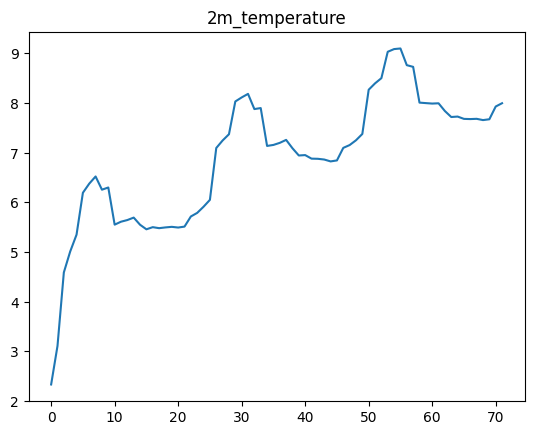

torch.Size([72])


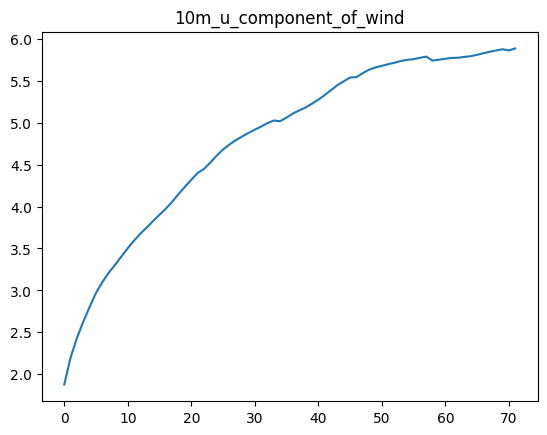

torch.Size([72])


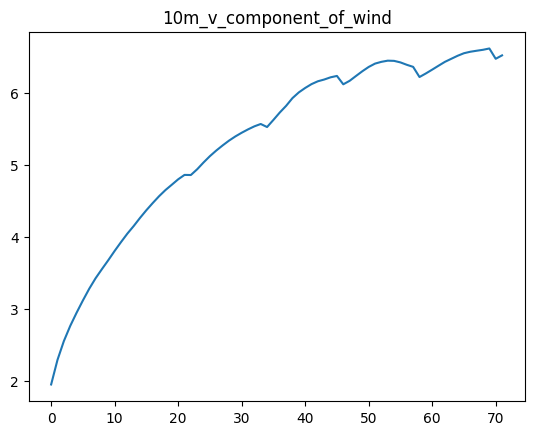

torch.Size([72])


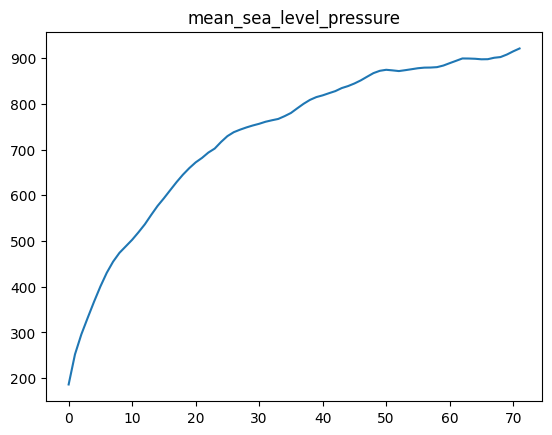

torch.Size([72])


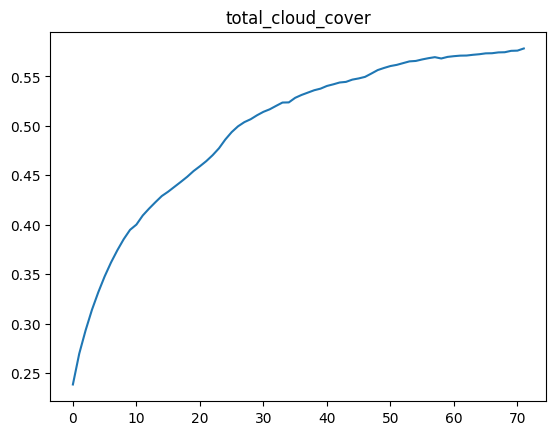

torch.Size([72])


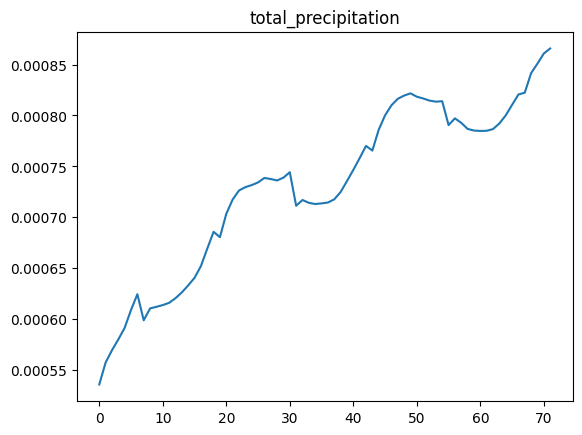

In [9]:
for i, var in enumerate(config.training.surface_variable):
        idx = len(config.training.air_variable) * len(config.training.levels) + i
        visualize(torch.sqrt(errors[idx]), var, isAIR=False)